In [7]:
import sys
import numpy as np
from skimage import color, io
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt
import pandas as pd

# setting path
sys.path.append("../colony_picker")
from picker import *

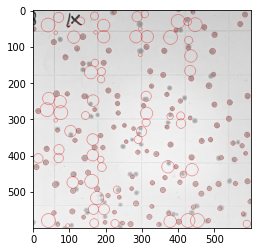

,x,y,quality
0,256,362,0.843750
1,237,515,0.812500
2,276,326,0.812500
3,368,232,0.900000
4,139,570,0.750000
...,...,...,...
174,446,40,0.169643
175,38,274,0.169643
176,426,579,0.169643
177,378,75,0.160714


In [41]:
def find_colonies(plate_processed, desired_count=192):
    image = plate_processed

    edges = canny(image)

    min_radius = 5
    max_radius = 20
    hough_radii = np.arange(5, 20, 1)  # TODO also needs to be adjusted. less numbers makes quicker
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(
        hough_res,
        hough_radii,
        min_xdistance=max_radius,
        min_ydistance=max_radius,
        total_num_peaks=desired_count,
        normalize=True,
    )

    #print(len(accums), len(cx), len(cy), len(radii))

    # Draw them
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = np.int16(
        np.interp(image, (image.min(), image.max()), (0, 255))
    )  # this rescales the image to be between 0 and 255
    cimage = color.gray2rgb(image)
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius, shape=cimage.shape)
        cimage[circy, circx] = (220, 20, 20)

    ax.imshow(cimage)
    plt.show()
    return accums, cx, cy

args = {
    'coord 1x':117,
    'coord 2x':470,
    'coord 3x':104,
    'coord 4x':466,
    'coord 1y':119,
    'coord 2y':119,
    'coord 3y':472,
    'coord 4y':474,
    'num colonies':180*2,
    'targetx':60,
    'targety':60,
}


img = io.imread('../data/img1_small.png')
img = np.asarray(img)[:, :, :3]
plate = color.rgb2gray(img)
flattened = flatten(plate, 400) #TODO needs to be adjusted for resolution of image?
warped = warp_squareplate(
    flattened, 
    [
        (args['coord 1x'], args['coord 1y']),
        (args['coord 2x'], args['coord 2y']),
        (args['coord 3x'], args['coord 3y']),
        (args['coord 4x'], args['coord 4y']),
    ],
    target=(args['targetx'], args['targety'])
    )

accums, cx, cy = find_colonies(
    warped,
    args["num colonies"]
)

df = pd.DataFrame(
    {
        'x':cx,
        'y':cy,
        'quality':accums,
    }
)
#mm_conversion_factor = args['targetwidth'] / (warped.shape[1] - (2*args['targetx']))
#df['x coord'] = df['x coord'].copy() - args['targetx']
#df['y coord'] = df['y coord'].copy() - args['targety']

df

Clearly this is too many with low quality. Sort by quality and then find the ones that are not too close to eachother.

In [42]:
def draw_colonies(cx: list, cy: list, image: np.array):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
    image = np.int16(
        np.interp(image, (image.min(), image.max()), (0, 255))
    )  # this rescales the image to be between 0 and 255
    cimage = color.gray2rgb(image)
    for center_y, center_x in zip(cy, cx):
        # to make them a bit bolder
        for r in range(10,12):
            circy, circx = circle_perimeter(center_y, center_x, r, shape=cimage.shape)
            cimage[circy, circx] = (220, 20, 20)

    ax.imshow(cimage)
    plt.show()


<AxesSubplot:>

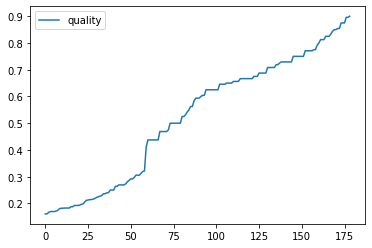

In [43]:
df.sort_values('quality').reset_index().plot(y='quality')

In [47]:
dfs = df[df['quality']>0.5] # not sure if this number can be hardcoded?

cx = dfs['x']
cy = dfs['y']

print("Colony count: ",len(cx))

Colony count:  100


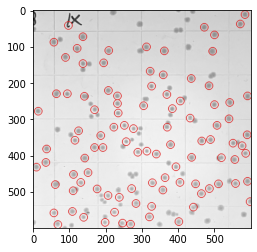

In [48]:
draw_colonies(cx, cy, warped)

In [49]:
5//2

2